## Data loading and summarization

In [1]:
from google.colab import files
uploaded = files.upload()

import pandas as pd


df = pd.read_csv('MachineLearningRating_v3.txt', sep='|')

print(df.describe())
df.info()

missing_values = df.isnull().sum().sort_values(ascending=False)
print(missing_values)


Saving MachineLearningRating_v3.txt to MachineLearningRating_v3.txt


/tmp/ipython-input-1-2239333905.py:7: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('MachineLearningRating_v3.txt', sep='|')


       UnderwrittenCoverID      PolicyID    PostalCode        mmcode  \
count         1.000098e+06  1.000098e+06  1.000098e+06  9.995460e+05   
mean          1.048175e+05  7.956682e+03  3.020601e+03  5.487770e+07   
std           6.329371e+04  5.290039e+03  2.649854e+03  1.360381e+07   
min           1.000000e+00  1.400000e+01  1.000000e+00  4.041200e+06   
25%           5.514300e+04  4.500000e+03  8.270000e+02  6.005692e+07   
50%           9.408300e+04  7.071000e+03  2.000000e+03  6.005842e+07   
75%           1.391900e+05  1.107700e+04  4.180000e+03  6.005842e+07   
max           3.011750e+05  2.324600e+04  9.870000e+03  6.506535e+07   

       RegistrationYear      Cylinders  cubiccapacity      kilowatts  \
count      1.000098e+06  999546.000000  999546.000000  999546.000000   
mean       2.010225e+03       4.046642    2466.743258      97.207919   
std        3.261391e+00       0.294020     442.800640      19.393256   
min        1.987000e+03       0.000000       0.000000       0.0

## Trend over time

<Axes: title={'center': 'Claims and Premium Over Time'}, xlabel='TransactionMonth'>

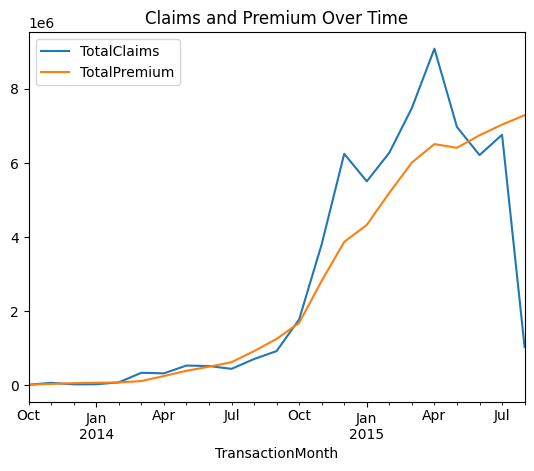

In [4]:
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])

# Select only numeric columns for summation
numeric_cols = df.select_dtypes(include=['number']).columns
monthly = df.groupby(pd.Grouper(key='TransactionMonth', freq='ME'))[numeric_cols].sum()

monthly[['TotalClaims', 'TotalPremium']].plot(title='Claims and Premium Over Time')

## Hypothesis Testing Setup

In [5]:
import numpy as np


df['ClaimOccurred'] = (df['TotalClaims'] > 0).astype(int)
df['ClaimFrequency'] = df.groupby('PostalCode')['ClaimOccurred'].transform('mean')

df['ClaimSeverity'] = np.where(df['ClaimOccurred'] == 1, df['TotalClaims'], np.nan)

In [6]:
from scipy.stats import f_oneway

df['LossRatio'] = df['TotalClaims'] / df['TotalPremium'].replace(0, np.nan)
groups = [group['LossRatio'].dropna() for _, group in df.groupby('Province')]
f_stat, p_value = f_oneway(*groups)
print(f"F-Stat: {f_stat}, p-value: {p_value}")

F-Stat: 4.988778295471582, p-value: 3.331023367970376e-06


##  ZipCode margin differences

In [7]:
df['Margin'] = df['TotalPremium'] - df['TotalClaims']
zipcode_margins = df.groupby('PostalCode')['Margin'].mean()
from scipy.stats import kruskal

grouped = df.groupby('PostalCode')['Margin'].apply(list)
filtered = [g for g in grouped if len(g) > 1]

if len(filtered) > 1:
    stat, p = kruskal(*filtered)
    print(f"Kruskal-Wallis p-value for ZipCodes: {p}")
else:
    print("Not enough valid Zip groups for Kruskal-Wallis test.")


Kruskal-Wallis p-value for ZipCodes: 0.0


## Gender differences in risk


In [8]:
import numpy as np
from scipy.stats import ttest_ind

df['LossRatio'] = df['TotalClaims'] / df['TotalPremium'].replace(0, np.nan)


male = df[df['Gender'] == 'Male']['LossRatio']
male = male[np.isfinite(male)]

female = df[df['Gender'] == 'Female']['LossRatio']
female = female[np.isfinite(female)]

t_stat, p_val = ttest_ind(male, female)
print(f"T-Test Gender: p = {p_val:.5f}")

T-Test Gender: p = 0.36189
